# Classification of normal urine and Paraquat poisoned cases

## Install required python modules

In [4]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [176]:
import numpy as np

filename_control = '../data/Sanity_check/Spectra_Mixt1.txt'
filename_case = '../data/Sanity_check/Spectra_Mix2.txt'
data_control = np.loadtxt(filename_control, dtype=float)
data_case = np.loadtxt(filename_case, dtype=float)

In [177]:
#Convert into dataframes
import pandas as pd

df_control = pd.DataFrame(data_control).T
df_case = pd.DataFrame(data_case).T

#Concatenate control and case df
df_NMR_intensities = pd.concat([df_control, df_case])
df_status = [0] * df_control.shape[0] + [1] * df_case.shape[0]

In [178]:
#Convert into tf.data
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_NMR_intensities, df_status))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [179]:
from tfrecords import write_tfrecords

In [180]:
write_tfrecords('../data/tfrecords/Sanity_check', dataset=dataset, number=10)

## Read the file

In [181]:
from tfrecords import read_tfrecords

In [216]:
file_paths = ['../data/tfrecords/Sanity_check/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords(file_paths)

## Process data

In [217]:
from models import process_dataset

In [218]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[10] * 3, shuffle_buffers=[1000] * 3,
                                                           train_prop=0.1, val_prop=0.9)

## Define Checkpoint

In [219]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/sanity_check")

## Define MLP

In [230]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(10000,), hidden_units=[16, 16])
simple_model.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_172 (Dense)            (None, 16)                160016    
_________________________________________________________________
dense_173 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [231]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(10000,), hidden_units=[1024, 1024, 1024, 512, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_175 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_102 (Bat (None, 1024)              4096      
_________________________________________________________________
dropout_102 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_176 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_103 (Bat (None, 1024)              4096      
_________________________________________________________________
dropout_103 (Dropout)        (None, 1024)            

## Compile models

In [232]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
# earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [233]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt])

Epoch 1/1000
2/2 [==============================] - 0s 74ms/step - loss: 60.7136 - binary_accuracy: 0.5000 - val_loss: 55.2747 - val_binary_accuracy: 0.4889
Epoch 2/1000
2/2 [==============================] - 0s 62ms/step - loss: 61.5873 - binary_accuracy: 0.4000 - val_loss: 33.2970 - val_binary_accuracy: 0.5611
Epoch 3/1000
2/2 [==============================] - 0s 54ms/step - loss: 47.6343 - binary_accuracy: 0.4000 - val_loss: 21.5875 - val_binary_accuracy: 0.5778
Epoch 4/1000
2/2 [==============================] - 0s 56ms/step - loss: 24.4044 - binary_accuracy: 0.6500 - val_loss: 19.3130 - val_binary_accuracy: 0.5833
Epoch 5/1000
2/2 [==============================] - 0s 58ms/step - loss: 18.0531 - binary_accuracy: 0.5500 - val_loss: 16.6750 - val_binary_accuracy: 0.6389
Epoch 6/1000
2/2 [==============================] - 0s 55ms/step - loss: 19.4068 - binary_accuracy: 0.5500 - val_loss: 17.1242 - val_binary_accuracy: 0.7000
Epoch 7/1000
2/2 [==============================] - 0s 54m

2/2 [==============================] - 0s 55ms/step - loss: 3.1216 - binary_accuracy: 0.9000 - val_loss: 3.2721 - val_binary_accuracy: 0.8167
Epoch 54/1000
2/2 [==============================] - 0s 51ms/step - loss: 7.9884 - binary_accuracy: 0.8000 - val_loss: 2.9829 - val_binary_accuracy: 0.8056
Epoch 55/1000
2/2 [==============================] - 0s 56ms/step - loss: 2.6413 - binary_accuracy: 0.8000 - val_loss: 2.2380 - val_binary_accuracy: 0.8389
Epoch 56/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.1410 - binary_accuracy: 0.8000 - val_loss: 1.8469 - val_binary_accuracy: 0.8500
Epoch 57/1000
2/2 [==============================] - 0s 53ms/step - loss: 1.4352 - binary_accuracy: 0.8500 - val_loss: 1.7410 - val_binary_accuracy: 0.8778
Epoch 58/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.4000 - binary_accuracy: 0.9000 - val_loss: 2.0151 - val_binary_accuracy: 0.8667
Epoch 59/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.54

2/2 [==============================] - 0s 50ms/step - loss: 5.5458 - binary_accuracy: 0.8500 - val_loss: 1.5545 - val_binary_accuracy: 0.9389
Epoch 106/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.6043 - binary_accuracy: 0.9000 - val_loss: 1.0028 - val_binary_accuracy: 0.9500
Epoch 107/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.1158 - binary_accuracy: 0.9500 - val_loss: 1.0944 - val_binary_accuracy: 0.9278
Epoch 108/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.2138 - binary_accuracy: 0.9000 - val_loss: 0.9844 - val_binary_accuracy: 0.9389
Epoch 109/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.4040 - binary_accuracy: 0.9500 - val_loss: 0.8533 - val_binary_accuracy: 0.9556
Epoch 110/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.8552 - binary_accuracy: 0.8500 - val_loss: 0.7980 - val_binary_accuracy: 0.9389
Epoch 111/1000
2/2 [==============================] - 0s 60ms/step - loss

Epoch 157/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 0.1251 - val_binary_accuracy: 0.9778
Epoch 158/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.0499e-10 - binary_accuracy: 1.0000 - val_loss: 0.2479 - val_binary_accuracy: 0.9889
Epoch 159/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0113 - binary_accuracy: 1.0000 - val_loss: 0.2047 - val_binary_accuracy: 0.9667
Epoch 160/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.1345e-04 - binary_accuracy: 1.0000 - val_loss: 0.4414 - val_binary_accuracy: 0.9500
Epoch 161/1000
2/2 [==============================] - 0s 55ms/step - loss: 0.1252 - binary_accuracy: 0.9500 - val_loss: 0.5087 - val_binary_accuracy: 0.9667
Epoch 162/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0258 - binary_accuracy: 1.0000 - val_loss: 1.0690 - val_binary_accuracy: 0.9444
Epoch 163/1000
2/2 [==============================

2/2 [==============================] - 0s 56ms/step - loss: 1.3650e-09 - binary_accuracy: 1.0000 - val_loss: 0.0871 - val_binary_accuracy: 0.9944
Epoch 209/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.8231e-08 - binary_accuracy: 1.0000 - val_loss: 0.0923 - val_binary_accuracy: 0.9889
Epoch 210/1000
2/2 [==============================] - 0s 57ms/step - loss: 4.3057e-05 - binary_accuracy: 1.0000 - val_loss: 0.0966 - val_binary_accuracy: 0.9889
Epoch 211/1000
2/2 [==============================] - 0s 50ms/step - loss: 4.1777e-05 - binary_accuracy: 1.0000 - val_loss: 0.1001 - val_binary_accuracy: 0.9889
Epoch 212/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.5082e-07 - binary_accuracy: 1.0000 - val_loss: 0.0073 - val_binary_accuracy: 0.9944
Epoch 213/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 0.0979 - val_binary_accuracy: 0.9944
Epoch 214/1000
2/2 [==============================] -

2/2 [==============================] - 0s 55ms/step - loss: 5.6286e-12 - binary_accuracy: 1.0000 - val_loss: 0.0771 - val_binary_accuracy: 0.9944
Epoch 260/1000
2/2 [==============================] - 0s 57ms/step - loss: 2.2032e-05 - binary_accuracy: 1.0000 - val_loss: 0.0772 - val_binary_accuracy: 0.9944
Epoch 261/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.6943 - binary_accuracy: 0.9500 - val_loss: 0.0704 - val_binary_accuracy: 0.9944
Epoch 262/1000
2/2 [==============================] - 0s 56ms/step - loss: 7.9455e-10 - binary_accuracy: 1.0000 - val_loss: 0.0588 - val_binary_accuracy: 0.9944
Epoch 263/1000
2/2 [==============================] - 0s 56ms/step - loss: 8.4430e-10 - binary_accuracy: 1.0000 - val_loss: 0.0493 - val_binary_accuracy: 0.9944
Epoch 264/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.4440 - binary_accuracy: 0.9500 - val_loss: 0.0285 - val_binary_accuracy: 0.9944
Epoch 265/1000
2/2 [==============================] - 0s 

2/2 [==============================] - 0s 53ms/step - loss: 2.3844e-07 - binary_accuracy: 1.0000 - val_loss: 2.3131e-05 - val_binary_accuracy: 1.0000
Epoch 310/1000
2/2 [==============================] - 0s 52ms/step - loss: 2.1631e-07 - binary_accuracy: 1.0000 - val_loss: 2.2067e-05 - val_binary_accuracy: 1.0000
Epoch 311/1000
2/2 [==============================] - 0s 59ms/step - loss: 4.8515e-06 - binary_accuracy: 1.0000 - val_loss: 2.2551e-05 - val_binary_accuracy: 1.0000
Epoch 312/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.0514e-04 - binary_accuracy: 1.0000 - val_loss: 1.7167e-05 - val_binary_accuracy: 1.0000
Epoch 313/1000
2/2 [==============================] - 0s 58ms/step - loss: 8.1245e-12 - binary_accuracy: 1.0000 - val_loss: 2.1341e-05 - val_binary_accuracy: 1.0000
Epoch 314/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.3500e-07 - binary_accuracy: 1.0000 - val_loss: 1.8128e-05 - val_binary_accuracy: 1.0000
Epoch 315/1000
2/2 [=====

Epoch 359/1000
2/2 [==============================] - 0s 50ms/step - loss: 2.1894e-07 - binary_accuracy: 1.0000 - val_loss: 1.2709e-05 - val_binary_accuracy: 1.0000
Epoch 360/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.1219e-05 - binary_accuracy: 1.0000 - val_loss: 1.6373e-05 - val_binary_accuracy: 1.0000
Epoch 361/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.3800e-07 - binary_accuracy: 1.0000 - val_loss: 1.5990e-05 - val_binary_accuracy: 1.0000
Epoch 362/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.7527e-05 - binary_accuracy: 1.0000 - val_loss: 1.4380e-05 - val_binary_accuracy: 1.0000
Epoch 363/1000
2/2 [==============================] - 0s 61ms/step - loss: 7.9285e-06 - binary_accuracy: 1.0000 - val_loss: 1.1934e-05 - val_binary_accuracy: 1.0000
Epoch 364/1000
2/2 [==============================] - 0s 57ms/step - loss: 3.6805e-05 - binary_accuracy: 1.0000 - val_loss: 1.6675e-05 - val_binary_accuracy: 1.0000
Epoch 365/

Epoch 409/1000
2/2 [==============================] - 0s 55ms/step - loss: 8.7370e-09 - binary_accuracy: 1.0000 - val_loss: 1.2371e-05 - val_binary_accuracy: 1.0000
Epoch 410/1000
2/2 [==============================] - 0s 57ms/step - loss: 6.8433e-06 - binary_accuracy: 1.0000 - val_loss: 1.1642e-05 - val_binary_accuracy: 1.0000
Epoch 411/1000
2/2 [==============================] - 0s 60ms/step - loss: 4.2835e-05 - binary_accuracy: 1.0000 - val_loss: 1.2353e-05 - val_binary_accuracy: 1.0000
Epoch 412/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.9309e-05 - binary_accuracy: 1.0000 - val_loss: 9.8180e-06 - val_binary_accuracy: 1.0000
Epoch 413/1000
2/2 [==============================] - 0s 52ms/step - loss: 2.7452e-06 - binary_accuracy: 1.0000 - val_loss: 1.2145e-05 - val_binary_accuracy: 1.0000
Epoch 414/1000
2/2 [==============================] - 0s 52ms/step - loss: 9.2881e-08 - binary_accuracy: 1.0000 - val_loss: 9.9160e-06 - val_binary_accuracy: 1.0000
Epoch 415/

Epoch 459/1000
2/2 [==============================] - 0s 54ms/step - loss: 7.4302e-06 - binary_accuracy: 1.0000 - val_loss: 8.2105e-06 - val_binary_accuracy: 1.0000
Epoch 460/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.7998e-05 - binary_accuracy: 1.0000 - val_loss: 6.5377e-06 - val_binary_accuracy: 1.0000
Epoch 461/1000
2/2 [==============================] - 0s 51ms/step - loss: 2.5094e-06 - binary_accuracy: 1.0000 - val_loss: 1.0244e-05 - val_binary_accuracy: 1.0000
Epoch 462/1000
2/2 [==============================] - 0s 54ms/step - loss: 4.4492e-05 - binary_accuracy: 1.0000 - val_loss: 9.4777e-06 - val_binary_accuracy: 1.0000
Epoch 463/1000
2/2 [==============================] - 0s 52ms/step - loss: 5.7642e-12 - binary_accuracy: 1.0000 - val_loss: 7.5109e-06 - val_binary_accuracy: 1.0000
Epoch 464/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.6573e-06 - binary_accuracy: 1.0000 - val_loss: 1.0061e-05 - val_binary_accuracy: 1.0000
Epoch 465/

Epoch 509/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.8849e-05 - binary_accuracy: 1.0000 - val_loss: 8.7500e-06 - val_binary_accuracy: 1.0000
Epoch 510/1000
2/2 [==============================] - 0s 55ms/step - loss: 2.2318e-05 - binary_accuracy: 1.0000 - val_loss: 8.7822e-06 - val_binary_accuracy: 1.0000
Epoch 511/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.2472e-05 - binary_accuracy: 1.0000 - val_loss: 8.7470e-06 - val_binary_accuracy: 1.0000
Epoch 512/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.3281e-08 - binary_accuracy: 1.0000 - val_loss: 8.1608e-06 - val_binary_accuracy: 1.0000
Epoch 513/1000
2/2 [==============================] - 0s 60ms/step - loss: 6.3530e-10 - binary_accuracy: 1.0000 - val_loss: 7.9986e-06 - val_binary_accuracy: 1.0000
Epoch 514/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.8472e-09 - binary_accuracy: 1.0000 - val_loss: 8.0820e-06 - val_binary_accuracy: 1.0000
Epoch 515/

Epoch 559/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.9859e-08 - binary_accuracy: 1.0000 - val_loss: 5.8473e-06 - val_binary_accuracy: 1.0000
Epoch 560/1000
2/2 [==============================] - 0s 55ms/step - loss: 3.2336e-11 - binary_accuracy: 1.0000 - val_loss: 7.9621e-06 - val_binary_accuracy: 1.0000
Epoch 561/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.4904e-06 - binary_accuracy: 1.0000 - val_loss: 7.2294e-06 - val_binary_accuracy: 1.0000
Epoch 562/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.9594e-06 - binary_accuracy: 1.0000 - val_loss: 7.8092e-06 - val_binary_accuracy: 1.0000
Epoch 563/1000
2/2 [==============================] - 0s 64ms/step - loss: 2.2245e-06 - binary_accuracy: 1.0000 - val_loss: 5.1948e-06 - val_binary_accuracy: 1.0000
Epoch 564/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.5482e-06 - binary_accuracy: 1.0000 - val_loss: 7.9280e-06 - val_binary_accuracy: 1.0000
Epoch 565/

Epoch 609/1000
2/2 [==============================] - 0s 55ms/step - loss: 5.2944e-10 - binary_accuracy: 1.0000 - val_loss: 7.1092e-06 - val_binary_accuracy: 1.0000
Epoch 610/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.4772e-05 - binary_accuracy: 1.0000 - val_loss: 7.0696e-06 - val_binary_accuracy: 1.0000
Epoch 611/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.7166e-05 - binary_accuracy: 1.0000 - val_loss: 7.0670e-06 - val_binary_accuracy: 1.0000
Epoch 612/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.6777e-05 - binary_accuracy: 1.0000 - val_loss: 7.0253e-06 - val_binary_accuracy: 1.0000
Epoch 613/1000
2/2 [==============================] - 0s 60ms/step - loss: 1.2560e-05 - binary_accuracy: 1.0000 - val_loss: 5.2853e-06 - val_binary_accuracy: 1.0000
Epoch 614/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.8253e-05 - binary_accuracy: 1.0000 - val_loss: 5.5731e-06 - val_binary_accuracy: 1.0000
Epoch 615/

Epoch 659/1000
2/2 [==============================] - 0s 51ms/step - loss: 5.8752e-08 - binary_accuracy: 1.0000 - val_loss: 6.3341e-06 - val_binary_accuracy: 1.0000
Epoch 660/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.4414e-05 - binary_accuracy: 1.0000 - val_loss: 6.1097e-06 - val_binary_accuracy: 1.0000
Epoch 661/1000
2/2 [==============================] - 0s 65ms/step - loss: 5.0402e-06 - binary_accuracy: 1.0000 - val_loss: 3.5339e-06 - val_binary_accuracy: 1.0000
Epoch 662/1000
2/2 [==============================] - 0s 53ms/step - loss: 5.3413e-06 - binary_accuracy: 1.0000 - val_loss: 5.7863e-06 - val_binary_accuracy: 1.0000
Epoch 663/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.6442e-06 - binary_accuracy: 1.0000 - val_loss: 6.2178e-06 - val_binary_accuracy: 1.0000
Epoch 664/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.1970e-06 - binary_accuracy: 1.0000 - val_loss: 6.0667e-06 - val_binary_accuracy: 1.0000
Epoch 665/

Epoch 709/1000
2/2 [==============================] - 0s 54ms/step - loss: 3.8724e-09 - binary_accuracy: 1.0000 - val_loss: 4.4057e-06 - val_binary_accuracy: 1.0000
Epoch 710/1000
2/2 [==============================] - 0s 56ms/step - loss: 4.2805e-08 - binary_accuracy: 1.0000 - val_loss: 5.6534e-06 - val_binary_accuracy: 1.0000
Epoch 711/1000
2/2 [==============================] - 0s 56ms/step - loss: 1.8500e-06 - binary_accuracy: 1.0000 - val_loss: 5.6384e-06 - val_binary_accuracy: 1.0000
Epoch 712/1000
2/2 [==============================] - 0s 61ms/step - loss: 4.4392e-06 - binary_accuracy: 1.0000 - val_loss: 5.6412e-06 - val_binary_accuracy: 1.0000
Epoch 713/1000
2/2 [==============================] - 0s 58ms/step - loss: 2.8693e-07 - binary_accuracy: 1.0000 - val_loss: 5.6323e-06 - val_binary_accuracy: 1.0000
Epoch 714/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.2610e-05 - binary_accuracy: 1.0000 - val_loss: 4.2765e-06 - val_binary_accuracy: 1.0000
Epoch 715/

Epoch 759/1000
2/2 [==============================] - 0s 53ms/step - loss: 4.7647e-08 - binary_accuracy: 1.0000 - val_loss: 5.2298e-06 - val_binary_accuracy: 1.0000
Epoch 760/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.1370e-05 - binary_accuracy: 1.0000 - val_loss: 3.9622e-06 - val_binary_accuracy: 1.0000
Epoch 761/1000
2/2 [==============================] - 0s 63ms/step - loss: 5.5760e-06 - binary_accuracy: 1.0000 - val_loss: 5.2025e-06 - val_binary_accuracy: 1.0000
Epoch 762/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.1533e-06 - binary_accuracy: 1.0000 - val_loss: 4.8597e-06 - val_binary_accuracy: 1.0000
Epoch 763/1000
2/2 [==============================] - 0s 53ms/step - loss: 1.0200e-05 - binary_accuracy: 1.0000 - val_loss: 4.6237e-06 - val_binary_accuracy: 1.0000
Epoch 764/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.6855e-11 - binary_accuracy: 1.0000 - val_loss: 4.1999e-06 - val_binary_accuracy: 1.0000
Epoch 765/

Epoch 809/1000
2/2 [==============================] - 0s 59ms/step - loss: 9.5325e-06 - binary_accuracy: 1.0000 - val_loss: 4.6806e-06 - val_binary_accuracy: 1.0000
Epoch 810/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.4266e-05 - binary_accuracy: 1.0000 - val_loss: 4.6320e-06 - val_binary_accuracy: 1.0000
Epoch 811/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.5481e-06 - binary_accuracy: 1.0000 - val_loss: 4.2426e-06 - val_binary_accuracy: 1.0000
Epoch 812/1000
2/2 [==============================] - 0s 53ms/step - loss: 8.7052e-06 - binary_accuracy: 1.0000 - val_loss: 3.1647e-06 - val_binary_accuracy: 1.0000
Epoch 813/1000
2/2 [==============================] - 0s 56ms/step - loss: 5.0140e-06 - binary_accuracy: 1.0000 - val_loss: 4.6423e-06 - val_binary_accuracy: 1.0000
Epoch 814/1000
2/2 [==============================] - 0s 54ms/step - loss: 1.1509e-09 - binary_accuracy: 1.0000 - val_loss: 4.6383e-06 - val_binary_accuracy: 1.0000
Epoch 815/

Epoch 859/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.4550e-11 - binary_accuracy: 1.0000 - val_loss: 4.1735e-06 - val_binary_accuracy: 1.0000
Epoch 860/1000
2/2 [==============================] - 0s 58ms/step - loss: 4.9599e-07 - binary_accuracy: 1.0000 - val_loss: 4.0335e-06 - val_binary_accuracy: 1.0000
Epoch 861/1000
2/2 [==============================] - 0s 53ms/step - loss: 4.5754e-08 - binary_accuracy: 1.0000 - val_loss: 4.2037e-06 - val_binary_accuracy: 1.0000
Epoch 862/1000
2/2 [==============================] - 0s 60ms/step - loss: 9.8628e-06 - binary_accuracy: 1.0000 - val_loss: 4.1969e-06 - val_binary_accuracy: 1.0000
Epoch 863/1000
2/2 [==============================] - 0s 62ms/step - loss: 5.4118e-06 - binary_accuracy: 1.0000 - val_loss: 3.7459e-06 - val_binary_accuracy: 1.0000
Epoch 864/1000
2/2 [==============================] - 0s 58ms/step - loss: 1.4186e-09 - binary_accuracy: 1.0000 - val_loss: 4.1741e-06 - val_binary_accuracy: 1.0000
Epoch 865/

Epoch 909/1000
2/2 [==============================] - 0s 55ms/step - loss: 6.2429e-08 - binary_accuracy: 1.0000 - val_loss: 3.5076e-06 - val_binary_accuracy: 1.0000
Epoch 910/1000
2/2 [==============================] - 0s 58ms/step - loss: 3.3488e-06 - binary_accuracy: 1.0000 - val_loss: 3.8698e-06 - val_binary_accuracy: 1.0000
Epoch 911/1000
2/2 [==============================] - 0s 59ms/step - loss: 3.4604e-07 - binary_accuracy: 1.0000 - val_loss: 3.1324e-06 - val_binary_accuracy: 1.0000
Epoch 912/1000
2/2 [==============================] - 0s 57ms/step - loss: 5.1343e-07 - binary_accuracy: 1.0000 - val_loss: 2.9726e-06 - val_binary_accuracy: 1.0000
Epoch 913/1000
2/2 [==============================] - 0s 55ms/step - loss: 7.5477e-06 - binary_accuracy: 1.0000 - val_loss: 3.6905e-06 - val_binary_accuracy: 1.0000
Epoch 914/1000
2/2 [==============================] - 0s 61ms/step - loss: 3.2636e-06 - binary_accuracy: 1.0000 - val_loss: 3.7386e-06 - val_binary_accuracy: 1.0000
Epoch 915/

Epoch 959/1000
2/2 [==============================] - 0s 52ms/step - loss: 9.6771e-06 - binary_accuracy: 1.0000 - val_loss: 3.0469e-06 - val_binary_accuracy: 1.0000
Epoch 960/1000
2/2 [==============================] - 0s 61ms/step - loss: 1.9223e-07 - binary_accuracy: 1.0000 - val_loss: 3.5817e-06 - val_binary_accuracy: 1.0000
Epoch 961/1000
2/2 [==============================] - 0s 57ms/step - loss: 1.4409e-06 - binary_accuracy: 1.0000 - val_loss: 2.8202e-06 - val_binary_accuracy: 1.0000
Epoch 962/1000
2/2 [==============================] - 0s 54ms/step - loss: 2.9782e-08 - binary_accuracy: 1.0000 - val_loss: 3.5717e-06 - val_binary_accuracy: 1.0000
Epoch 963/1000
2/2 [==============================] - 0s 55ms/step - loss: 1.5154e-09 - binary_accuracy: 1.0000 - val_loss: 3.3978e-06 - val_binary_accuracy: 1.0000
Epoch 964/1000
2/2 [==============================] - 0s 59ms/step - loss: 1.6363e-07 - binary_accuracy: 1.0000 - val_loss: 3.5469e-06 - val_binary_accuracy: 1.0000
Epoch 965/

## Plot the learning curves

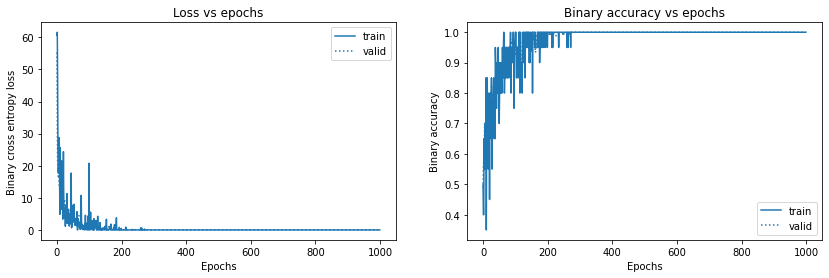

In [235]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()